# Compressed Sensing: Application à l'IRM
    GARNIER Rémy (M2 StatML), NGUYEN Dinh-Phong (M2 Data Science)

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from IPython import display
warnings.filterwarnings('ignore')
%matplotlib inline

#### Abstract

L'imagerie par résonance magnétique (IRM) est un procédé qui permet d'acquérir des images et des données sur l'état de santé d'un patient. La théorie du Compressed Sensing a de nombreuses applications dans le monde médical, et notamment pour l'Imagerie par Résonance Magnétique (IRM). Réduire le temps d’acquisition en réduisant le nombre de données à collecter présente un grand attrait étant donnée la durée importante de certaines acquisitions IRM.

## Principe

Si on impose un champ magnétique de gradient spatial $\vec(G)$ sur un objet $m(\vec{r})$ la réponse reçue par l'appareil  est :

$$ s(t) = \int m(\vec{r}) e^{- i 2 \pi \vec{k(t)}\cdot \vec{r}} dr $$

avec $ \vec{k(t)} \propto \int_{0}^t \vec{G}(t) $. C'est donc la transformée de Fourrier spatiale de l'objet $m(\vec{r})$ échantilloné à la fréquence $\vec{k(t)}$. On peut faire varier cette fréquence au cours de différentes acquisitions, en jouant sur le champ magnétique. On veut pouvoir reconstruire l'objet en récoltant suffisament de point de mesure pour des valeurs de $\vec{k(t)}$ différentes. 

Une première méthode pour reconstruire l'objet consisterait à considérer un échantillonage régulier dans le k-space, c'est à dire l'ensemble des valeurs de  $\vec{k(t)}$ possibles, et de procéder à la reconstruction par tranformée de Fourier inverse. Si le nombre de points de mesure est supérieur au critère Nyquist, on peut reconstruire  l'image initiale.

Cependant, en se servant du fait que les données sont naturellement sparse pour un certain encodage (par exemple par ondelettes), on pourrait n'utiliser qu'un faible nombre de mesures pour reconstruire l'image d'origine.

Une question importante est le choix des points (vecteurs) de mesures dans le $k$-space. En particulier, on peut essayer de regarder ce qu'il se passe dans le cas d'un échantillonage régulier dans le k-space. Dans la suite on va comparer un tel échantillonage à un échantillonage aléatoire.

## Reconstruction

Générons un vecteur $x$ de longueur 100 avec 5 cœfficients non nuls positionnés aléatoirement, représentant un signal quelconque 5-sparse que nous allons essayer de reconstruire à partir d'échantillons de mesures dans le $k$-space.

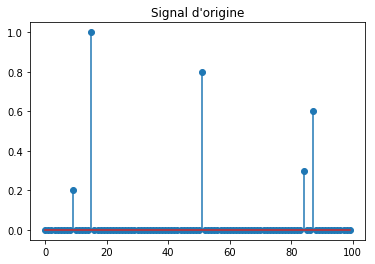

In [2]:
x = np.array([0.2, 0.3, 0.6, 0.8, 1.] + [0] * 95)
np.random.seed(42)
np.random.shuffle(x)
plt.stem(x)
plt.title('Signal d\'origine');

Prenons la transformation de Fourier discrète de ce vecteur, $X = \mathcal{F}x$, où $\mathcal{F}$ représente la matrice de Vandermonde-Fourier:

In [3]:
X = np.fft.fft(x)

L'objectif principal du compressed sensing est de pouvoir reconstruire le signal d'origine à partir d'une "information incomplète" (nombre de mesures limité) sur celui-ci. Il est en général impossible de reconstruire $x$ uniquement à partir des coefficients de Fourier car la transformée de Fourier est une bijection de $\mathbb{C}^N$. Néanmoins, si l'on sait que le signal d'origine $x$ est $s$-sparse, on se trouve bien dans le cadre du compressed sensing.

Prenons alors un sous-échantillon $X_u = \mathcal{F}_u x$ de $X$, où $\mathcal{F}_u$ est une matrice de Vandermonde-Fourier évaluée sur seulement une partie du domaine de fréquences. Nous allons comparer deux cas de sous-échantillonage dans le domaine de Fourier:

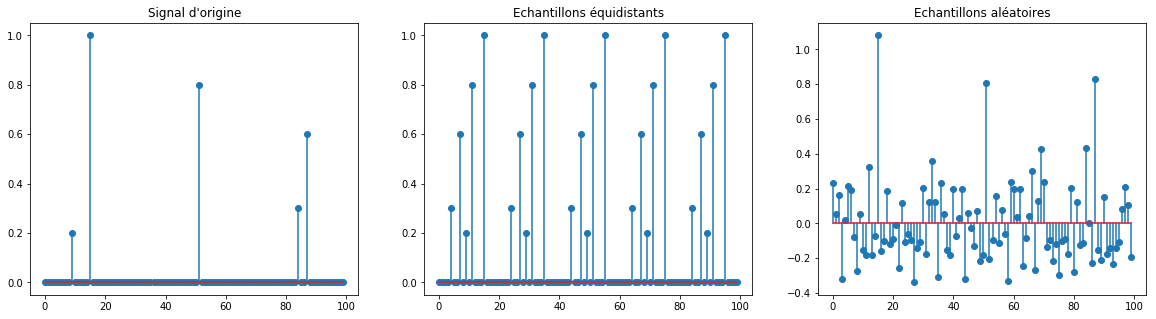

In [4]:
Xu = np.zeros(100, dtype='complex')
Xu[::5] = X[::5]

Xr = np.zeros(100, dtype='complex')
sample_idx = np.random.choice(100, 20)
Xr[sample_idx] = X[sample_idx]

# Transformée inverse
xu = np.fft.ifft(Xu) * 5
xr = np.fft.ifft(Xr) * 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].stem(x)
ax[0].set_title('Signal d\'origine')
ax[1].stem(xu)
ax[1].set_title('Echantillons équidistants')
ax[2].stem(xr)
ax[2].set_title('Echantillons aléatoires');

On peut intuitivement se dire que la reconstruction du signal sera plus facile avec un sous-échantillonnage aléatoire; l'intensité des signaux semble identique périodiquement pour les échantillons équidistants, et on risque d'avoir des difficultés à déterminer sélectionner les bons.

## Algorithme

On veut résoudre un problème de minimisation l1:
$$ \min_{x}{\| x\|_1} \quad \mbox{tel que} \quad \|(\mathcal{F} \cdot x )_S-y\|_2 < \epsilon$$

Que l'on peut aussi le réécrire sous la forme
$$ \hat x = \underset{x}{\text{Argmin}} \frac{1}{2} ||(\mathcal{F} \cdot x)_S-y||_2^2 + \lambda ||x||_1 $$

Nous appliquerons un algorithme similaire à l'Iterative Hard Thresholding (IHT) vu en cours : ** projected Iterative Soft Thresholding Algorithm (pISTA)** (https://arxiv.org/abs/1504.07786)

* On part de $X_0 = y$ et $x_0 =\mathcal{F}^{-1}  X_0$ 
* Tant que que $|| x_{i+1} -  x_i ||_2 < \epsilon$: 
    * Transformée de Fourier inversée pour obtenir $ x_i = \mathcal{F}^{-1} \cdot X_i$
    * Seuillage de $x_i$. On annule toutes les composantes de $x_i$ inférieures à $\lambda$
    * Transformée de Fourier $ X_{i+1} = \mathcal{F} \cdot x_i$
    * On impose les conditions sur le support $(X_{i+1})_S = y$


In [5]:
def SoftThresh(y, t):
    x_hat = (y / np.abs(y)) * np.maximum(np.abs(y)-t, 0)
    return x_hat

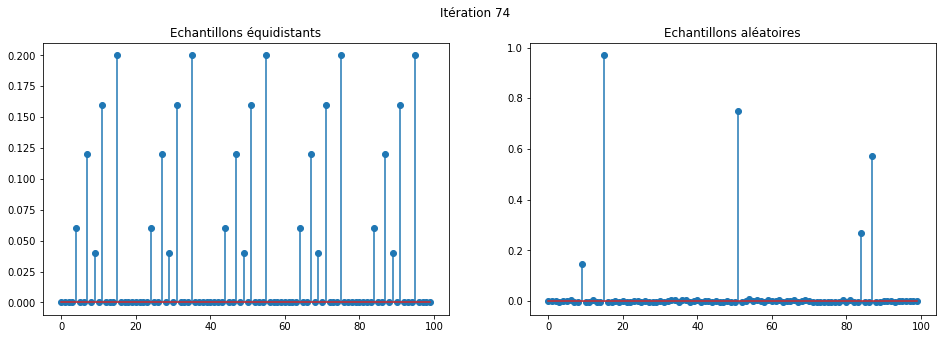

In [6]:
l = 0.01
n_iter = 75

Y1 = Xu # Echantillons équidistants
Y2 = Xr # Echantillons aléatoires
Xi1 = Y1
Xi2 = Y2

for i in range(n_iter):
    xi1 = np.fft.ifft(Xi1) # Transformée de Fourier inverse
    xi1_st = SoftThresh(xi1.real, l) # Seuillage doux
    Xi1 = np.fft.fft(xi1_st) # Transformée de Fourier
    Xi1 = Xi1 * (Y1==0) + Y1
    
    xi2 = np.fft.ifft(Xi2)
    xi2_st = SoftThresh(xi2.real, l)
    Xi2 = np.fft.fft(xi2_st)
    Xi2 = Xi2 * (Y2==0) + Y2
    
    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].stem(xi1.real)
    ax[0].set_title('Echantillons équidistants')
    ax[1].stem(xi2.real)
    ax[1].set_title('Echantillons aléatoires')
    plt.suptitle('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

On a donc bien réussi à reconstruire le signal d'origine dans le cas du sous-échantillonnage aléatoire. On remarque que même les coefficients initialement "noyés" dans le bruit ont pu être récupérés.

## Incohérence

Soit $\mathcal{B}_e = (e_j)_{j=1}^N$ et $\mathcal{B}_f = (f_j)_{j=1}^N$ deux bases orthonormales de $\mathbb{R}^N$. On dit qu'elles sont \textbf{incohérentes} quand $\forall{i,j}$ on a: $$|\langle e_i|f_j \rangle| \leq \frac{Cst}{\sqrt{N}}$$

* C'est le cas de la base de Fourier avec la base canonique
* Les vecteurs de mesure $X_i$ doivent être incohérents avec la base dans laquelle s'exprime la sparsité des signaux

Comme on l'a vu plus haut, la reconstruction du signal a été possible avec le sous-échantillonnage aléatoire; la théorie du Compressed Sensing nous dit en effet que les vecteurs de mesure aléatoires remplissent ce critère d'incohérence.

## Application à l'IRM

En IRM, les données sont acquises directement dans l’espace de Fourier de l’image (et non dans l'espace des pixels), encore appelé $k$-space. On mesure ainsi un ensemble de valeurs de la transformée de Fourier d’une image. L’application du Compressed Sensing en IRM permet de recueillir moins de mesures que préconisé par le critère de Nyquist (chaque oscillation doit être sondée au moins une fois), puis à reconstruire une image grâce à des algorithmes itératifs non-linéaires (comme le seuillage doux itératif). Pour ce faire, les mesures acquises dans le $k$-space doivent être distribuées selon une certaine densité dépendant de la structure de parcimonie du signal d'origine. En pratique, on doit échantillonner de façon plus dense les basses fréquences.

Dans ce qui suit, nous allons donc simuler l'acquisition d'une IRM cérébrale (séquence T2) dans le $k$-space:

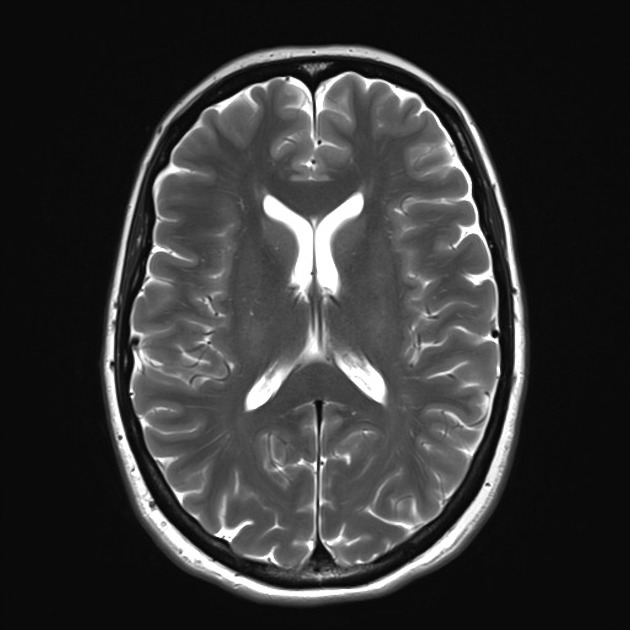

In [7]:
# On charge un exemple d'IRM cérébral
brain = Image.open("brain_mri.jpeg")
brain

In [8]:
brain_array = np.array(brain)
brain_fourier = np.fft.fft2(brain_array) # Transformée de Fourier 2D (=données acquises en pratique)
brain_fourier_shift = np.fft.fftshift(brain_fourier) # Mise au centre des coordonnées nulles
brain_fourier_powerspect = np.abs(brain_fourier_shift) ** 2

Reconstruction error:  0.0


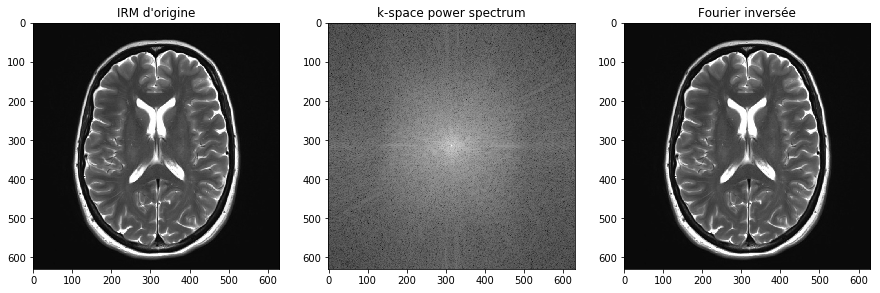

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.array(brain), cmap='gray')
ax[0].set_title('IRM d\'origine')
ax[1].imshow(np.log10(brain_fourier_powerspect.real), cmap='gray')
ax[1].set_title('k-space power spectrum')
ax[2].imshow(np.fft.ifft2(brain_fourier).real, cmap='gray')
ax[2].set_title('Fourier inversée');

error = np.abs(np.linalg.norm(brain) - np.linalg.norm(np.fft.ifft2(brain_fourier_shift))) / np.linalg.norm(brain)
print('Reconstruction error: ', error)

Pour nous assurer de la cohérence de notre démarche jusqu'ici, nous observons bien une reconstruction identique à l'image d'origine en prenant la transformée de Fourier inverse. Voyons maintenant ce qu'il se passe si on sous-échantillonne des colonnes de la matrice des signaux dans le $k$-space aléatoirement. Il existe plusieurs schémas de sous-échantillonage; nous nous intéressons ici d'abord au cas le plus simple, qui est celui de vecteurs de mesure parallèles aléatoirement sélectionnés sur la grille Cartésienne.

Reconstruction error:  0.00517995721388


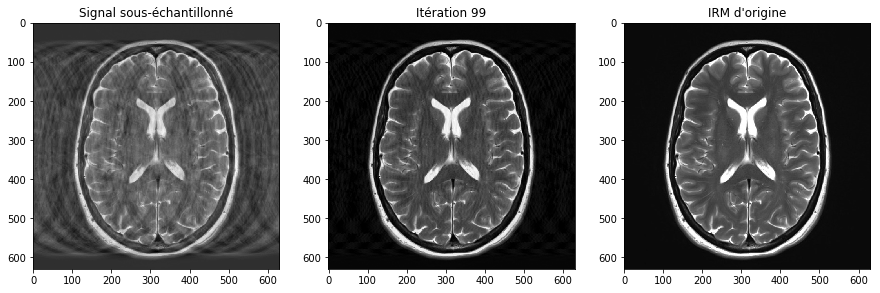

In [86]:
l = 3.
n_iter = 100

brain_under = np.zeros(brain_fourier.shape, dtype='complex')

p = 0.70 # Pourcentage de coefficients conservés
np.random.seed(42)
mask = np.random.binomial(1, p, size=brain_fourier.shape[0]).astype(np.bool)
brain_under[:,mask] = brain_fourier_shift[:,mask]
brain_under = np.fft.ifftshift(brain_under)
brain_rec = np.fft.ifft2(brain_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain_rec.real, cmap='gray')
ax[0].set_title('Signal sous-échantillonné')
ax[2].imshow(np.array(brain), cmap='gray')
ax[2].set_title('IRM d\'origine')

Y = brain_under
Xi = Y

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, l)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y

    ax[1].imshow(xi.real, cmap='gray')
    ax[1].set_title('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(brain) - np.linalg.norm(xi)) / np.linalg.norm(brain)
print('Reconstruction error: ', error)

Le résultat obtenu est certes correct, mais il a fallu garder 70% des mesures dans le $k$-space pour obtenir ce résultat. On voit également des artefacts linéaires dans le cerveau en lui même, qui est la région d'intérêt. Essayons un autre schéma de sous-échantillonnage du $k$-space, basée sur une densité de probabilité gaussienne à deux dimensions, centrée sur zéro. En effet, sur le plot du $k$-space plus haut, nous avons vu que l'essentiel du signal se concentre au centre (proche de zero). Un sous-échantillonnage à densité variable donnant un plus grand poids au centre serait donc en théorie plus adapté, tout en gardant les propriétés d'incohérence vues plus haut.

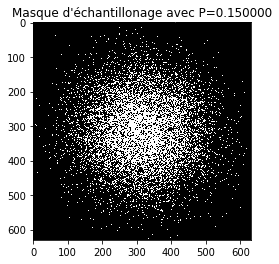

In [83]:
# Filtre gaussien 2D
x, y = np.meshgrid(np.linspace(-1,1,630), np.linspace(-1,1,630))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.3, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

# Masque pour échantillonner selon le filtre gaussien
np.random.seed(42)
P = 0.15
N = int(P * (630*630))
result = np.zeros((630,630))
ia = np.arange(result.size)
tw = float(np.sum(g.ravel()))
result.ravel()[np.random.choice(ia, p=g.ravel()/tw, size=N, replace=False)]=1

plt.imshow(result, cmap='gray')
plt.title('Masque d\'échantillonage avec P=%f' % P);

Reconstruction error:  0.00817569187537


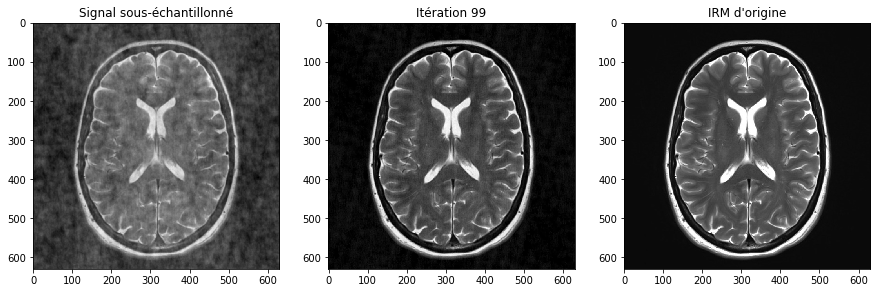

In [88]:
brain_under = brain_fourier_shift * result
brain_under = np.fft.ifftshift(brain_under)
brain_rec = np.fft.ifft2(brain_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain_rec.real, cmap='gray')
ax[0].set_title('Signal sous-échantillonné')
ax[2].imshow(np.array(brain), cmap='gray')
ax[2].set_title('IRM d\'origine')

Y = brain_under
Xi = Y

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, l)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y

    ax[1].imshow(xi.real, cmap='gray')
    ax[1].set_title('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(brain) - np.linalg.norm(xi)) / np.linalg.norm(brain)
print('Reconstruction error: ', error)

L'erreur de reconstruction est du même ordre que précédemment, mais cette fois-ci il ne nous a fallu que 15% des mesures dans le $k$-space ! Ce qui est logique, car dans le $k$-space, les mesures les plus importantes sont concentrées autour de l'origine. En outre, il n'y a plus les artefacts linéaires apparus avec le sous-échantillonnage Cartésien; l'image reconstruite avec le sous-échantillonnage gaussien semble être visuellement plus proche de la véritable image. Outre le nombre de mesures gardées, il est donc crucial de déterminer le bon schéma de sous-échantillonnage (Cartésien, radial, spiralé, etc.). En pratique, il est plus facile d'utiliser un sous-échantillonnage suivant une grille Cartésienne (ou du moins un schéma régulier); un sous-échantillonnage trop "chaotique" serait plus vulnérable à des problèmes techniques venant de la machine. Certains papiers plus récents combinent les deux méthodes vues ici : le sous-échantillonnage se fait selon une grille Cartésienne, dont les lignes et colonnes sont sélectionnées selon une densité de probabilité avec un poids supérieur au centre du $k$-space.

## Références

[1] Lustig, Mike, D. L. Donoho, J. M. Santos and J. M. Pauly. “Compressed Sensing MRI.” IEEE Signal Processing Magazine 25 (2008): 72-82.


[2] Lustig, M. , Donoho, D. and Pauly, J. M. (2007), Sparse MRI: The application of compressed sensing for rapid MR imaging. Magn. Reson. Med., 58: 1182-1195. doi:10.1002/mrm.21391


[3] Nicolas Chauffert, Philippe Ciuciu, Jonas Kahn, Pierre Weiss. Variable density sampling with continuous trajectories. Application to MRI.. SIAM Journal of Imaging Sciences, 2014, 7 (4), pp.1962-1992.


[4] Liu Y. et al. Projected Iterative Soft-thresholding Algorithm for Tight Frames in Compressed Sensing Magnetic Resonance Imaging (https://arxiv.org/abs/1504.07786)